Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 9.894s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
Fitting the classifier to the training set
done in 28.003s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
done in 0.066s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       1.00      0.81      0.89        36

         accuracy                           0.85 

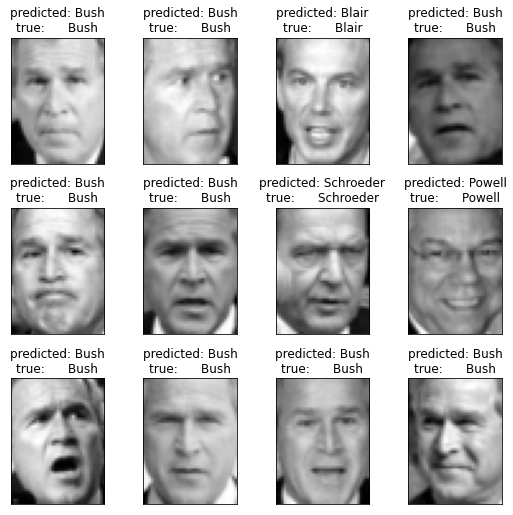

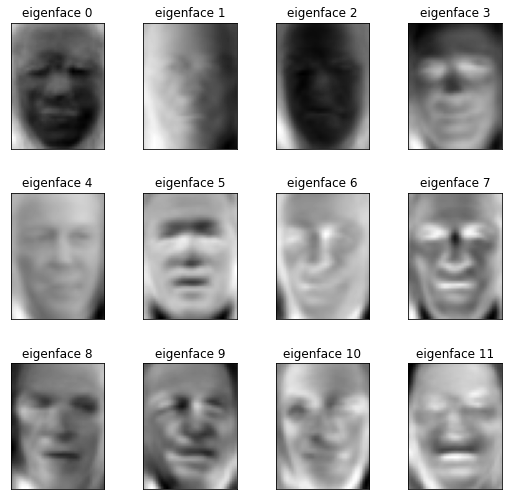

In [3]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## Question 4.1

In [32]:
# Replace the learner in the original program with a random forest 
# classifier using scikit-learn

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classification model

print("Fitting the classifier to the training set")
t0 = time()
clf = RandomForestClassifier(n_estimators=500,max_depth=10,random_state=42)
clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 2.711s


In [33]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.061s
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.88      0.48      0.62        60
  Donald Rumsfeld       0.50      0.04      0.07        27
    George W Bush       0.51      1.00      0.68       146
Gerhard Schroeder       1.00      0.04      0.08        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       1.00      0.06      0.11        36

         accuracy                           0.56       322
        macro avg       0.56      0.23      0.22       322
     weighted avg       0.63      0.56      0.45       322

[[  0   1   1  11   0   0   0]
 [  0  29   0  31   0   0   0]
 [  0   0   1  26   0   0   0]
 [  0   0   0 146   0   0   0]
 [  0   1   0  23   1   0   0]
 [  0   1   0  14   0   0   0]
 [  0   1   0  33   0   0   2]]


/home/sachin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Question 4.2

In [42]:
# Replace the learner in the original program with a multilayer perceptron (having two hidden layers with 15 and 10 neurons respectively)
# using scikit-learn

from sklearn.neural_network import MLPClassifier

# Train a multilayer perceptron  classification model
t0 = time()
clf = MLPClassifier(hidden_layer_sizes=(15,10), random_state=42)
clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

done in 1.324s


/home/sachin/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.005s
                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.62      0.59        13
     Colin Powell       0.68      0.80      0.73        60
  Donald Rumsfeld       0.73      0.70      0.72        27
    George W Bush       0.88      0.85      0.86       146
Gerhard Schroeder       0.57      0.64      0.60        25
      Hugo Chavez       0.58      0.47      0.52        15
       Tony Blair       0.80      0.67      0.73        36

         accuracy                           0.76       322
        macro avg       0.69      0.68      0.68       322
     weighted avg       0.77      0.76      0.76       322

[[  8   2   1   2   0   0   0]
 [  4  48   1   4   2   1   0]
 [  0   2  19   5   0   0   1]
 [  1  11   4 124   4   2   0]
 [  0   2   0   2  16   2   3]
 [  0   3   0   2   1   7   2]
 [  1   3   1   2   5   0  24]]


## Question 4.3

In [64]:
# Replace the learner in the original program with a deep convolutional neural network 
# using the Keras or TensorFlow library

X = lfw_people.data
y = lfw_people.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train = X_train.reshape(X_train.shape[0],50,37,1)
X_test = X_test.reshape(X_test.shape[0],50,37,1)


In [65]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_train = to_categorical(y_train,7)
y_test = label.fit_transform(y_test)
y_test = to_categorical(y_test,7)

In [68]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(966, 50, 37, 1)
(966, 7)
(322, 50, 37, 1)
(322, 7)


In [71]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

model = Sequential()
model.add(Conv2D(256,(7,7),strides=(1, 1), padding='same',activation='relu',input_shape=(50,37,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(7,7),strides=(1, 1), padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3)) 
model.add(Conv2D(64,(7,7),strides=(1, 1), padding='same',activation='relu'))
model.add(Conv2D(64,(7,7),strides=(1, 1), padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 50, 37, 256)       12800     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 18, 256)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 25, 18, 256)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 18, 128)       1605760   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 9, 128)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 12, 9, 128)       

In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train,epochs=50,validation_data=(X_test,y_test),batch_size=16,verbose=1)

Epoch 1/50
61/61 [==============================] - 38s 595ms/step - loss: 4.5811 - accuracy: 0.3540 - val_loss: 1.6173 - val_accuracy: 0.4534
Epoch 2/50
61/61 [==============================] - 36s 595ms/step - loss: 1.7439 - accuracy: 0.3903 - val_loss: 1.7390 - val_accuracy: 0.4534
Epoch 3/50
61/61 [==============================] - 38s 626ms/step - loss: 1.7298 - accuracy: 0.3965 - val_loss: 1.6207 - val_accuracy: 0.4534
Epoch 4/50
61/61 [==============================] - 38s 616ms/step - loss: 1.7164 - accuracy: 0.3975 - val_loss: 1.5831 - val_accuracy: 0.4534
Epoch 5/50
61/61 [==============================] - 38s 618ms/step - loss: 1.7146 - accuracy: 0.3975 - val_loss: 1.6974 - val_accuracy: 0.4534
Epoch 6/50
61/61 [==============================] - 38s 630ms/step - loss: 1.6925 - accuracy: 0.3986 - val_loss: 1.5194 - val_accuracy: 0.4596
Epoch 7/50
61/61 [==============================] - 38s 628ms/step - loss: 1.6816 - accuracy: 0.4037 - val_loss: 1.5816 - val_accuracy: 0.4534

In [75]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
11/11 [==============================] - 2s 185ms/step - loss: 0.5552 - accuracy: 0.8199
Test Accuracy: 81.98757767677307


## Question 4.4

Accuracy for k = 2:  0.4114906832298137
Accuracy for k = 4:  0.4114906832298137
Accuracy for k = 6:  0.4114906832298137
Accuracy for k = 7:  0.43478260869565216
Accuracy for k = 8:  0.4200310559006211
Accuracy for k = 10:  0.4309006211180124
Accuracy for k = 12:  0.4301242236024845
Accuracy for k = 14:  0.43711180124223603


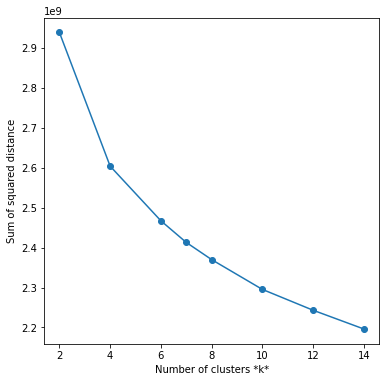

In [127]:
# Use a clustering method of your choice to cluster the images, and measure how accurately
# the clusters correspond to the sets of images of one person/object

from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import accuracy_score

X = lfw_people.data
y = lfw_people.target

def get_reference_dict(clusters,y):
    reference_label = {}
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(y[index==1]).argmax()
        reference_label[i] = num
    return reference_label
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

sse = []
list_k = [2,4,6,7,8,10,12,14]
for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(X)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters,y)
    predicted_labels = get_labels(clusters,reference_labels)
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,y))
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [166]:
km = KMeans(n_clusters=7, max_iter=100, random_state=42)
km.fit(X)
labels = km.predict(X)

In [167]:
centroids = km.cluster_centers_

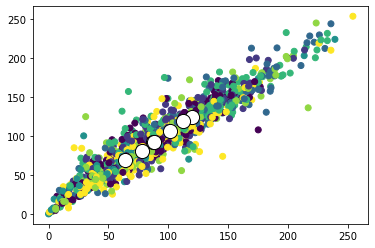

In [168]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

In [169]:
from sklearn import metrics
score = metrics.accuracy_score(y,km.predict(X))
print("Accuracy: ", score*100)

Accuracy:  12.732919254658384


## Question 4.4

Complete the report on: Ethical and social impact(s) of applications of artificial intelligence in the field of image recognition 

## Advanced tasks for highier grades

### Question1

In [131]:
# Applying hyper-parameter optimisation to task 2 and discussing the method and results.


from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classification model

print("Fitting the classifier to the training set")
t0 = time()
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)


CV_rfc.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 858.829s


In [132]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [133]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [134]:
rfc1.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [136]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = rfc1.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))

Predicting people's names on the test set
done in 0.073s
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.00      0.00      0.00        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.97      0.46      0.62       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

        micro avg       0.97      0.21      0.34       322
        macro avg       0.14      0.07      0.09       322
     weighted avg       0.44      0.21      0.28       322
      samples avg       0.21      0.21      0.21       322



/home/sachin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sachin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Question 3

In [142]:
from skimage import exposure

Accuracy:  11.956521739130435


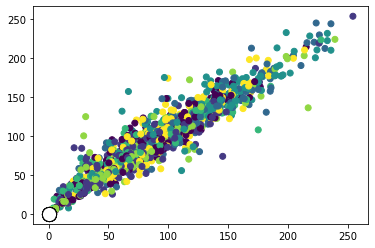

In [165]:
X = lfw_people.data
y = lfw_people.target

# Applying Histogram Equalization
X_new = exposure.equalize_hist(X)

km = KMeans(n_clusters=7, max_iter=100, random_state=42)
km.fit(X_new)
labels = km.predict(X_new)

centroids = km.cluster_centers_

import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

from sklearn import metrics
score = metrics.accuracy_score(y,km.predict(X_new))
print("Accuracy: ", score*100)

After doing histogram equalization, we can see the accuracy didn't imporve.